# understanding AA pair reactivity trends

# Summary

no signficant stacking trends

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress, ttest_ind
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from tabulate import tabulate
import py3Dmol

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    plot_motif_boxplot_stripplot,
    plot_violins_w_percent,
    plot_violins_w_percent_groups,
    format_small_plot,
)
from dms_3d_features.format_tables import (
    dataframe_column_table,
    generate_threshold_summary,
    heatmap_table,
)
from dms_3d_features.stats import r2, check_pairwise_statistical_significance

## extra functions

In [3]:
def visualize_molecule(row, width=400, height=300):
    viewer = py3Dmol.view(width=width, height=height)
    viewer.addModel(open("../" + row["pdb_path"], "r").read(), "pdb")

    # Set color scheme for nucleotides
    nucleotide_colors = {"A": "red", "U": "green", "C": "blue", "G": "orange"}
    for nuc, color in nucleotide_colors.items():
        viewer.setStyle({"resn": nuc}, {"stick": {"color": color}})

    viewer.zoomTo()

    residue_number = row["pdb_r_pos"]
    viewer.addStyle({"resi": str(residue_number)}, {"stick": {"color": "magenta"}})

    # Highlight N1 for A or N3 for C
    if row["r_nuc"] == "A":
        viewer.addStyle(
            {"resi": str(residue_number), "atom": "N1"},
            {"sphere": {"radius": 1.0, "color": "magenta"}},
        )
    elif row["r_nuc"] == "C":
        viewer.addStyle(
            {"resi": str(residue_number), "atom": "N3"},
            {"sphere": {"radius": 1.0, "color": "magenta"}},
        )

    return viewer

### plotting

In [4]:
def plot_residue_trends(df, color="tab:gray", col="ln_r_data"):
    fig = plt.figure(figsize=(3.0, 3.0), dpi=200)
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[:, 1])

    # 5' Residue
    data_range = df[col].max() - df[col].min()
    extra_space = 0.4 * data_range
    xlim_min = df[col].min() - extra_space
    xlim_max = df[col].max()

    plot_violins_w_percent(
        df,
        col,
        "p5_res",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax1,
    )
    ax1.set_ylabel("5' Residue", labelpad=2)
    ax1.set_xlabel(f"{col}", labelpad=2)
    format_small_plot(ax1)

    # 3' Residue
    plot_violins_w_percent(
        df,
        col,
        "p3_res",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax2,
    )
    ax2.set_ylabel("3' Residue", labelpad=2)
    ax2.set_xlabel(f"{col}", labelpad=2)
    format_small_plot(ax2)

    # Residue Stack
    plot_violins_w_percent(
        df,
        col,
        "r_stack",
        color=color,
        gt_lt="less",
        xlim=(xlim_min, xlim_max),
        text_offset=extra_space,
        sorted_by_mean=True,
        ax=ax3,
    )
    ax3.set_ylabel("Residue Stack", labelpad=2)
    ax3.set_xlabel(f"{col}", labelpad=2)
    format_small_plot(ax3)
    plt.tight_layout()

In [5]:
def plot_flanking_pairs_distribution(df):
    # Combine the flanking pairs into a single column
    df["flanking_pairs"] = df["m_second_flank_bp_5p"] + "-" + df["m_second_flank_bp_3p"]
    # Calculate mean r_data_ratio for each flanking pair
    mean_r_data_ratio = (
        df.groupby("flanking_pairs")["r_data_ratio"].mean().sort_values(ascending=False)
    )
    # Create the rotated violin plot
    plt.figure(figsize=(5, 4))
    sns.violinplot(
        x="r_data_ratio",
        y="flanking_pairs",
        data=df,
        order=mean_r_data_ratio.index[::-1],
        cut=0,
        orient="h",
        density_norm="width",
    )
    # Customize the plot
    plt.title("Distribution of r_data_ratio for Different Flanking Pairs")
    plt.xlabel("r_data_ratio")
    plt.ylabel("Flanking Pairs (5' - 3')")
    plt.xlim([0, 10])
    # Add count labels
    counts = df["flanking_pairs"].value_counts()
    for i, flanking_pair in enumerate(mean_r_data_ratio.index[::-1]):
        count = counts[flanking_pair]
        plt.text(plt.xlim()[1] + 0.5, i, f"n={count}", ha="left", va="center")

### summary tables

In [6]:
def create_summary_table(df, y_column):
    # Calculate percentages and counts
    summary = []
    for y_value in df[y_column].unique():
        group = df[df[y_column] == y_value]
        percent_over = (group["ln_r_data"] < -5.45).mean() * 100
        count = len(group)
        summary.append([y_value, f"{percent_over:.2f}%", count])

    # Sort by percentage descending
    summary.sort(key=lambda x: float(x[1][:-1]), reverse=True)

    # Create table
    headers = [y_column, "% Under -5.45", "Count"]
    table = tabulate(summary, headers=headers, tablefmt="pipe", floatfmt=".2f")

    print(f"Summary table for {y_column}:")
    print(table)

In [7]:
def analyze_flanking_pairs(df):
    # Calculate the mean of r_data_ratio for each combination of m_second_flank_bp_5p and m_second_flank_bp_3p
    mean_r_data_ratio = (
        df.groupby(["m_second_flank_bp_5p", "m_second_flank_bp_3p"])["r_data_ratio"]
        .mean()
        .reset_index()
    )
    # Pivot the table to create a matrix-like structure
    pivot_table = mean_r_data_ratio.pivot(
        index="m_second_flank_bp_5p",
        columns="m_second_flank_bp_3p",
        values="r_data_ratio",
    )
    # Sort the index and columns alphabetically
    pivot_table = pivot_table.sort_index().sort_index(axis=1)
    # Display the results as a styled table
    display(pivot_table.style.format("{:.1f}").background_gradient(cmap="YlOrRd"))
    # Calculate the count of occurrences for each combination
    count_table = (
        df.groupby(["m_second_flank_bp_5p", "m_second_flank_bp_3p"])
        .size()
        .reset_index(name="count")
    )
    pivot_count = count_table.pivot(
        index="m_second_flank_bp_5p", columns="m_second_flank_bp_3p", values="count"
    )
    pivot_count = pivot_count.sort_index().sort_index(axis=1)
    # Display the count table
    display(pivot_count.style.format("{:.1f}").background_gradient(cmap="Blues"))

### misc

In [8]:
def assign_stack_type(row):
    if row["both_pyrimidine"]:
        return "both_pyrimidine"
    elif row["both_purine"]:
        return "both_purine"
    else:
        return "mixed"

In [9]:
def add_side_diff_column(df):
    df["side_diff"] = [
        abs(int(x.split("x")[0]) - int(x.split("x")[1])) for x in df["m_token"]
    ]
    df["side_diff"] = df["side_diff"].astype(str)
    return df

## load data

In [10]:
DATA_PATH = "../data"

In [11]:
df_constructs = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
# pdb dataframe
df_pdb = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues_pdb.json")
df_pdb_aa = df_pdb.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and pdb_r_pair == 'A-A' and no_of_interactions == 1"
).copy()

In [12]:
dataframe_column_table(df_pdb)

                  0                  1                          2                    3
         m_sequence              r_nuc                  pdb_r_pos          partner_nuc
    pdb_partner_pos             r_type              pdb_r_bp_type           pdb_r_pair
no_of_conformations no_of_interactions no_of_partner_interactions             pdb_name
           pdb_path            pdb_res                both_purine      both_pyrimidine
         constructs        likely_pair              m_flank_bp_5p        m_flank_bp_3p
      m_orientation              m_pos       m_second_flank_bp_5p m_second_flank_bp_3p
        m_structure            m_token                     n_pdbs            pair_type
             p5_res            p5_type                     p3_res              p3_type
             r_data          r_loc_pos                      r_pos              r_stack
          ln_r_data            z_score             r_data_outlier       pair_pdb_r_pos


# All residues

## percent under -5.45

In [13]:
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
print(len(df_aa["m_sequence"].unique()))

169


In [14]:
df_cc = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
generate_threshold_summary(df_cc, "r_nuc", greater_than=False)

Summary table for r_nuc:
| r_nuc   | % < -5.45   |   Count |
|:--------|:------------|--------:|
| A       | 6.63%       |   26446 |


In [15]:
df_aa = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA' and m_token == '1x1'"
).copy()
generate_threshold_summary(df_aa, "r_nuc", greater_than=False)

Summary table for r_nuc:
| r_nuc   | % < -5.45   |   Count |
|:--------|:------------|--------:|
| A       | 4.62%       |     866 |


## Stacking trends

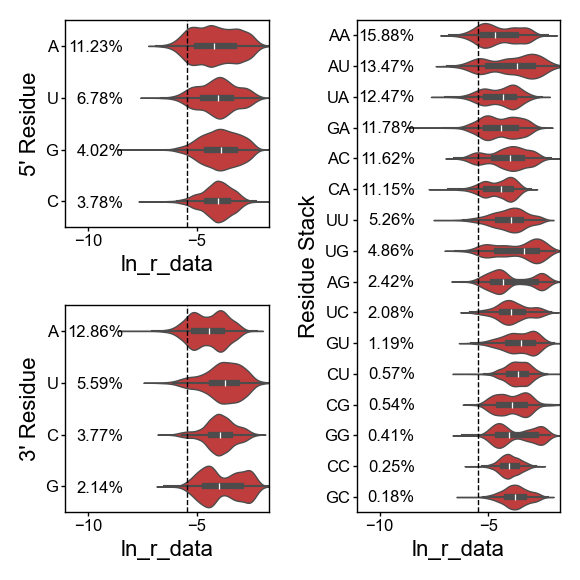

In [16]:
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
plot_residue_trends(df_aa, color="tab:red")

In [17]:
# Example usage:
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
p_values_df = check_pairwise_statistical_significance(df_aa, "r_stack", "ln_r_data")
p_values_df.sort_values(by="p-value", ascending=True)

,Group 1,Group 2,p-value
56,CA,CU,4.477255e-285
58,CA,GC,2.712519e-247
60,CA,GU,2.263035e-230
6,AA,CU,2.134566e-220
88,CU,UA,1.319331e-215
...,...,...,...
3,AA,CA,5.696991e-01
95,GA,UA,5.827174e-01
51,AU,UC,6.398255e-01
90,CU,UG,8.678416e-01


In [18]:
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
p_values_df = check_pairwise_statistical_significance(df_aa, "p5_res", "ln_r_data")
p_values_df.sort_values(by="p-value", ascending=True)

,Group 1,Group 2,p-value
1,A,G,7.169208e-46
3,C,G,8.937500e-30
5,G,U,3.919105e-17
2,A,U,3.605718e-10
0,A,C,8.208881e-07
4,C,U,3.972950e-02


In [19]:
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
p_values_df = check_pairwise_statistical_significance(df_aa, "p3_res", "ln_r_data")
p_values_df.sort_values(by="p-value", ascending=True)

,Group 1,Group 2,p-value
0,A,C,0.000000e+00
1,A,G,0.000000e+00
2,A,U,0.000000e+00
4,C,U,2.521329e-22
3,C,G,7.419531e-16
5,G,U,2.782849e-01


/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


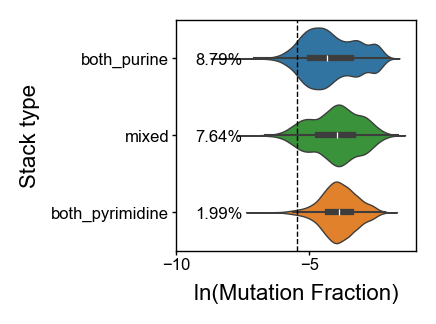

In [20]:
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
df_aa["stack_type"] = df_aa.apply(assign_stack_type, axis=1)
ax = plot_violins_w_percent(
    df_aa,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
format_small_plot(ax)

In [21]:
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
create_summary_table(df_aa, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| AA        | 15.88%          |    2110 |
| AU        | 13.47%          |    1655 |
| UA        | 12.47%          |    2238 |
| GA        | 11.78%          |    1825 |
| AC        | 11.62%          |    1825 |
| CA        | 11.15%          |    2036 |
| UU        | 5.26%           |    1425 |
| UG        | 4.86%           |    1483 |
| AG        | 2.42%           |    1612 |
| UC        | 2.08%           |    1635 |
| GU        | 1.19%           |    1256 |
| CU        | 0.57%           |    1408 |
| CG        | 0.54%           |    1475 |
| GG        | 0.41%           |    1212 |
| CC        | 0.25%           |    1624 |
| GC        | 0.18%           |    1627 |


# Ratio in reactivity

In [22]:
df_aa = df.query("r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA'").copy()
new_rows = []
count = 0
# first row is lower reactivity
for i, group in df_aa.groupby(["m_sequence", "constructs", "m_pos"]):
    if len(group) == 2:
        sorted_group = group.sort_values(by="r_data", ascending=True)
        new_row = sorted_group.iloc[1].copy()
        new_row["r_data_ratio"] = (
            sorted_group.iloc[1]["r_data"] / sorted_group.iloc[0]["r_data"]
        )
        new_row["r_data_other"] = sorted_group.iloc[0]["r_data"]
        new_row["r_stack_other"] = sorted_group.iloc[0]["r_stack"]
        new_row["p5_res_other"] = sorted_group.iloc[0]["p5_res"]
        new_row["p3_res_other"] = sorted_group.iloc[0]["p3_res"]
        new_rows.append(new_row)
    else:
        count += 1
df_aa_combined = pd.DataFrame(new_rows)

In [23]:
df_pdb_aa = df_pdb.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and pdb_r_pair == 'A-A'"
).copy()
new_rows = []
count = 0
for i, group in df_pdb_aa.groupby(["m_sequence", "constructs", "m_pos", "pdb_name"]):
    if len(group) == 2:
        sorted_group = group.sort_values(by="r_data", ascending=True)
        new_row = sorted_group.iloc[1].copy()
        new_row["r_data_ratio"] = (
            sorted_group.iloc[1]["r_data"] / sorted_group.iloc[0]["r_data"]
        )
        new_row["r_data_other"] = sorted_group.iloc[0]["r_data"]
        new_row["r_stack_other"] = sorted_group.iloc[0]["r_stack"]
        new_row["p5_res_other"] = sorted_group.iloc[0]["p5_res"]
        new_row["p3_res_other"] = sorted_group.iloc[0]["p3_res"]
        new_rows.append(new_row)
    else:
        count += 1
df_pdb_aa_combined = pd.DataFrame(new_rows)

In [24]:
df_aa_combined = df_aa_combined.sort_values(by="r_data_ratio", ascending=False)

In [25]:
dataframe_column_table(df_aa_combined)
### what is related to large ratios in reactivity

           0                    1                    2             3
 both_purine      both_pyrimidine           constructs      has_pdbs
 likely_pair        m_flank_bp_5p        m_flank_bp_3p m_orientation
       m_pos m_second_flank_bp_5p m_second_flank_bp_3p    m_sequence
 m_structure              m_token               n_pdbs     pair_type
      p5_res              p5_type               p3_res       p3_type
      r_data                r_nuc            r_loc_pos         r_pos
      r_type              r_stack             pdb_path     pdb_r_pos
   ln_r_data              z_score       r_data_outlier  r_data_ratio
r_data_other        r_stack_other         p5_res_other  p3_res_other


### what is related to large ratios in reactivity

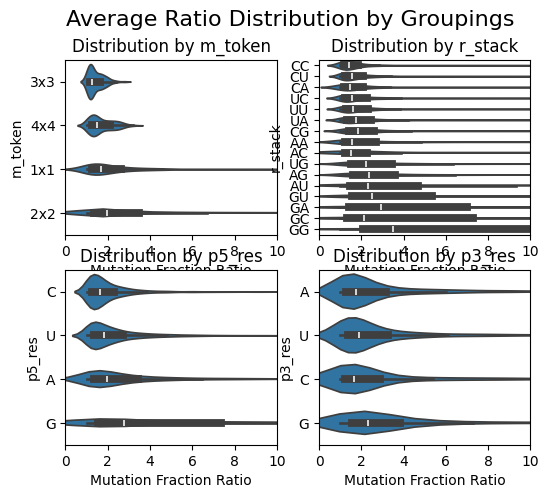

In [26]:
# Calculate average ratio for different groupings
groupings = ["m_token", "r_stack", "p5_res", "p3_res"]

fig, axes = plt.subplots(2, 2, figsize=(6, 5))
fig.suptitle("Average Ratio Distribution by Groupings", fontsize=16)

for idx, group in enumerate(groupings):
    row = idx // 2
    col = idx % 2
    # Calculate mean r_data_ratio for each group and sort by mean
    sorted_data = (
        df_aa_combined.groupby(group)["r_data_ratio"].mean().sort_values().index
    )
    sorted_df = df_aa_combined.set_index(group).loc[sorted_data].reset_index()

    # Create violin plot
    sns.violinplot(
        x="r_data_ratio",
        y=group,
        data=sorted_df,
        ax=axes[row, col],
        orient="h",
    )

    axes[row, col].set_title(f"Distribution by {group}")
    axes[row, col].set_xlabel("Mutation Fraction Ratio")
    axes[row, col].set_ylabel(group)
    axes[row, col].set_xlim(0, 10)

In [27]:
df_pdb_aa_combined.groupby("pdb_r_bp_type").agg(
    avg_ratio=("r_data_ratio", "mean"),
    std_ratio=("r_data_ratio", "std"),
    count=("r_data_ratio", "size"),
).reset_index().sort_values(by="avg_ratio", ascending=False)

,pdb_r_bp_type,avg_ratio,std_ratio,count
6,tHS,4.973637,3.446827,672
10,tWW,2.883901,2.194918,402
5,tHH,2.738219,1.516323,413
0,cHS,2.376293,1.033813,1041
4,cWW,2.188589,1.692505,471
7,tHW,2.041719,1.051760,41
9,tWH,1.900432,0.845219,63
3,cWH,1.874868,1.211529,100
8,tSH,1.621654,0.610285,187
1,cHW,1.547999,0.471422,130


In [28]:
# Create a table with average r_data_ratio, pdb_r_bp_type, and pdb_res for each PDB
pdb_summary = (
    df_pdb_aa_combined.groupby("pdb_name")
    .agg(
        {
            "r_data_ratio": "mean",
            "pdb_r_bp_type": lambda x: x.mode().iloc[0] if not x.empty else None,
            "pdb_res": lambda x: x.mode().iloc[0] if not x.empty else None,
        }
    )
    .reset_index()
)

# Sort the table by average r_data_ratio in descending order
pdb_summary = pdb_summary.sort_values("r_data_ratio", ascending=False)

# Rename columns for clarity
pdb_summary.columns = ["PDB Name", "Avg Ratio", "BP Type", "Res"]

print(tabulate(pdb_summary, headers="keys", tablefmt="psql", showindex=False))

+--------------------------------------------+-------------+-----------+-------+
| PDB Name                                   |   Avg Ratio | BP Type   |   Res |
|--------------------------------------------+-------------+-----------+-------|
| TWOWAY.5O5J.2-2.AAAG-CGAU.0.pdb            |     6.95329 | tHS       |  3.45 |
| TWOWAY.1NJP.2-3.CUAU-AAACG.0.pdb           |     6.89479 | tHS       |  3.5  |
| TWOWAY.4IOA.2-3.CUAU-AAACG.0.pdb           |     6.89479 | tHS       |  3.2  |
| TWOWAY.6QKL.2-3.UAAU-AGAAA.0.pdb           |     4.96776 | tHS       |  3.3  |
| TWOWAY.5UNE.1-1.UAG-CAG.0.pdb              |     4.3436  | cWW       |  2.9  |
| TWOWAY.5UNE.1-1.CAG-UAG.0.pdb              |     4.3436  | cWW       |  2.9  |
| TWOWAY.6NEQ.1-1.UAG-UAA.0.pdb              |     4.18558 | tHS       |  3.32 |
| NWAY.1UN6.2-5-0.AAUA-UUAGUAC-GG.0.pdb      |     4.10626 | tHH       |  3.1  |
| TWOWAY.6YS3.5-3.UAUGUAG-UGAAA.0.pdb        |     3.32373 | tWW       |  2.58 |
| TWOWAY.4KQY.3-6.CAGAG-CGAC

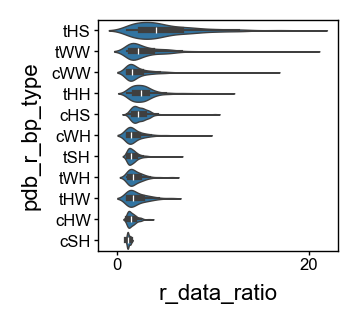

In [81]:
fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)
ax = sns.violinplot(
    y="pdb_r_bp_type",
    x="r_data_ratio",
    data=df_pdb_aa_combined.sort_values(by="r_data_ratio", ascending=False),
    linewidth=0.5,
    density_norm="width",
)
format_small_plot(ax)

In [30]:
# Calculate descriptive statistics
desc_stats = df_aa_combined["r_data_ratio"].describe()

# Calculate coefficient of variation
cv = desc_stats["std"] / desc_stats["mean"]

# Print descriptive statistics and coefficient of variation
print(desc_stats)
print(f"\nCoefficient of Variation: {cv:.4f}")

count    11669.000000
mean         3.510942
std          4.902830
min          1.000000
25%          1.356924
50%          1.931250
75%          3.411449
max        113.762712
Name: r_data_ratio, dtype: float64

Coefficient of Variation: 1.3964


In [31]:
(
    df_aa_combined.groupby(["r_stack"])
    .agg(
        avg_ratio=("r_data_ratio", "mean"),
        std_ratio=("r_data_ratio", "std"),
        count=("r_data_ratio", "size"),
        cv_ratio=("r_data_ratio", lambda x: x.std() / x.mean()),
    )
    .reset_index()
    .sort_values(by="avg_ratio", ascending=False)
)

,r_stack,avg_ratio,std_ratio,count,cv_ratio
10,GG,8.348920,11.028224,1023,1.320916
9,GC,5.281749,6.636045,944,1.256411
8,GA,5.137484,5.393461,761,1.049825
11,GU,4.224753,4.099510,881,0.970355
3,AU,4.029367,4.469374,599,1.109200
2,AG,3.022103,2.251595,762,0.745042
14,UG,2.896934,2.208420,1169,0.762330
1,AC,2.561218,3.626024,411,1.415742
0,AA,2.404434,2.001395,402,0.832377
6,CG,2.325242,1.581458,1086,0.680126


In [32]:
(
    df_aa_combined.groupby(["r_stack_other"])
    .agg(
        avg_ratio=("r_data_ratio", "mean"),
        std_ratio=("r_data_ratio", "std"),
        count=("r_data_ratio", "size"),
        cv_ratio=("r_data_ratio", lambda x: x.std() / x.mean()),
    )
    .reset_index()
    .sort_values(by="avg_ratio", ascending=False)
)

,r_stack_other,avg_ratio,std_ratio,count,cv_ratio
4,CA,7.028484,10.483367,1226,1.491555
8,GA,6.837611,7.343685,670,1.074013
12,UA,4.693194,5.113890,908,1.089640
0,AA,4.079702,3.996978,946,0.979723
15,UU,3.434028,3.842720,893,1.119012
5,CC,3.015531,2.539357,1183,0.842093
3,AU,2.500340,1.522772,677,0.609026
9,GC,2.444384,2.903870,683,1.187976
1,AC,2.434818,1.464876,1020,0.601637
13,UC,2.407583,1.626111,1040,0.675412


In [33]:
# Calculate the average, standard deviation, count, and coefficient of variation of r_data_ratio for each combination of r_stack and r_stack_other
summary_table = (
    df_aa_combined.groupby(["r_stack", "r_stack_other"])
    .agg(
        avg_ratio=("r_data_ratio", "mean"),
        std_ratio=("r_data_ratio", "std"),
        count=("r_data_ratio", "size"),
    )
    .reset_index()
)

# Calculate coefficient of variation
summary_table["cv_ratio"] = summary_table["std_ratio"] / summary_table["avg_ratio"]

# Sort the summary table by highest average ratio
summary_table = summary_table.sort_values(by="avg_ratio", ascending=False)

# Print the summary table using tabulate
print("Summary Table of r_stack and r_stack_other:")
print(
    tabulate(
        summary_table,
        headers=[
            "r_stack",
            "r_stack_other",
            "Average Ratio",
            "Std Ratio",
            "Count",
            "CV Ratio",
        ],
        floatfmt=".2f",
        tablefmt="pipe",
    )
)

Summary Table of r_stack and r_stack_other:
|    | r_stack   | r_stack_other   |   Average Ratio |   Std Ratio |   Count |   CV Ratio |
|---:|:----------|:----------------|----------------:|------------:|--------:|-----------:|
| 59 | GG        | CA              |           17.45 |       13.32 |     395 |       0.76 |
| 53 | GC        | GA              |           10.33 |        7.72 |     399 |       0.75 |
| 48 | GA        | UA              |            8.39 |        5.82 |     393 |       0.69 |
| 63 | GU        | AA              |            7.25 |        4.75 |     370 |       0.66 |
| 21 | AU        | UU              |            5.05 |        5.28 |     357 |       1.04 |
| 40 | CG        | UG              |            4.34 |        2.77 |      40 |       0.64 |
| 82 | UG        | CC              |            4.32 |        2.82 |     390 |       0.65 |
| 85 | UG        | UA              |            4.19 |        3.24 |      40 |       0.77 |
| 12 | AG        | CC              |

In [34]:
# Filter the dataframe for rows where r_stack == 'GG' and r_stack_other == 'CA'
filtered_df = df_aa_combined[
    (df_aa_combined["r_stack"] == "GG") & (df_aa_combined["r_stack_other"] == "CA")
]

# Get the list of unique m_sequences
unique_m_sequences = filtered_df["m_sequence"].unique()

# Print the list of unique m_sequences
print("List of unique m_sequences with r_stack == 'GG' and r_stack_other == 'CA':")
print(unique_m_sequences)

List of unique m_sequences with r_stack == 'GG' and r_stack_other == 'CA':
['AGAG&CAAU' 'CAAA&UGAG' 'CAAC&GGAG' 'CAAG&CGAG']


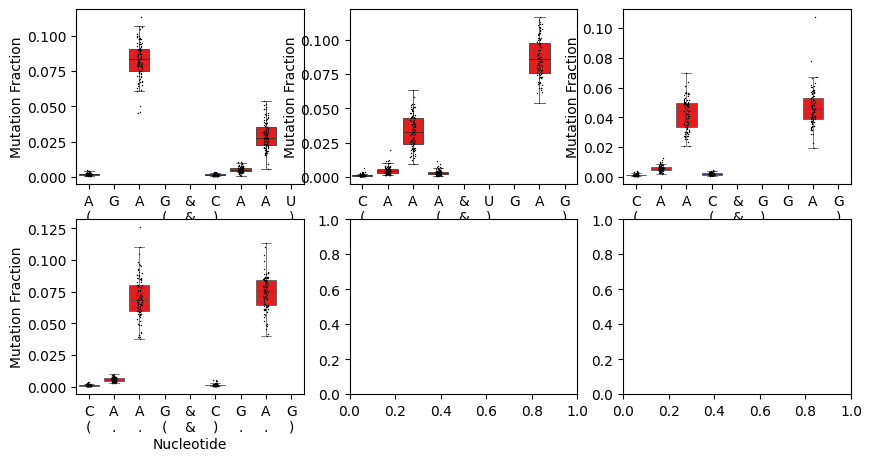

In [35]:
# Determine the number of rows and columns for the subplots
num_sequences = len(unique_m_sequences)
num_cols = 3
num_rows = (num_sequences + num_cols - 1) // num_cols

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 2.5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# For each unique m_sequence, generate a boxplot and stripplot in subplots
for idx, sequence in enumerate(unique_m_sequences):
    # Filter the dataframe for the current m_sequence
    sequence_df = df[df["m_sequence"] == sequence]
    plot_motif_boxplot_stripplot(sequence_df, show_structure=True, ax=axes[idx])

Text(95.72222222222221, 0.5, 'r_stack')

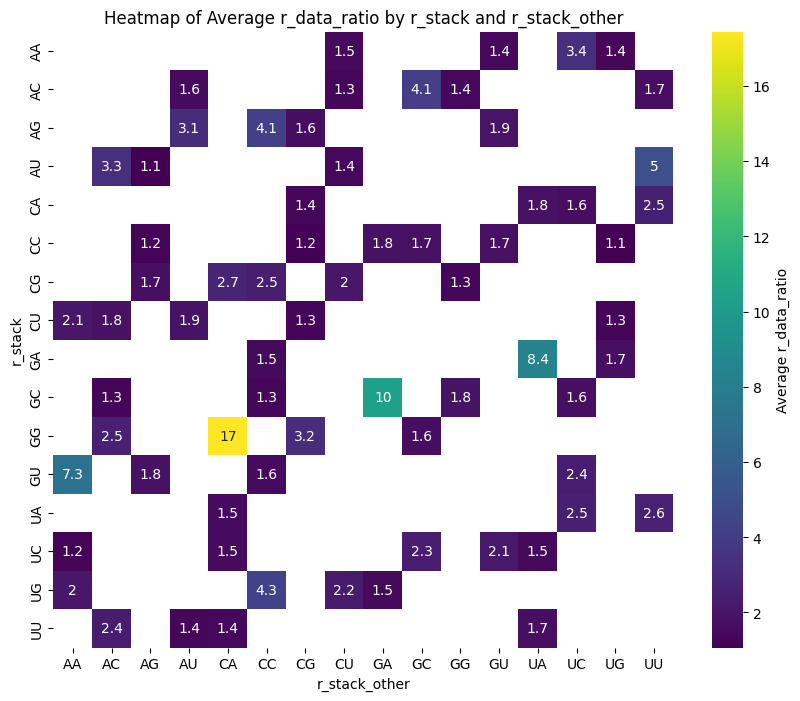

In [36]:
# Create a pivot table for the heatmap
df_sub = df_aa_combined.query("m_token == '2x2'")
heatmap_data = df_sub.pivot_table(
    index="r_stack", columns="r_stack_other", values="r_data_ratio", aggfunc="mean"
)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data, annot=True, cmap="viridis", cbar_kws={"label": "Average r_data_ratio"}
)
plt.title("Heatmap of Average r_data_ratio by r_stack and r_stack_other")
plt.xlabel("r_stack_other")
plt.ylabel("r_stack")

Text(95.72222222222221, 0.5, 'r_stack')

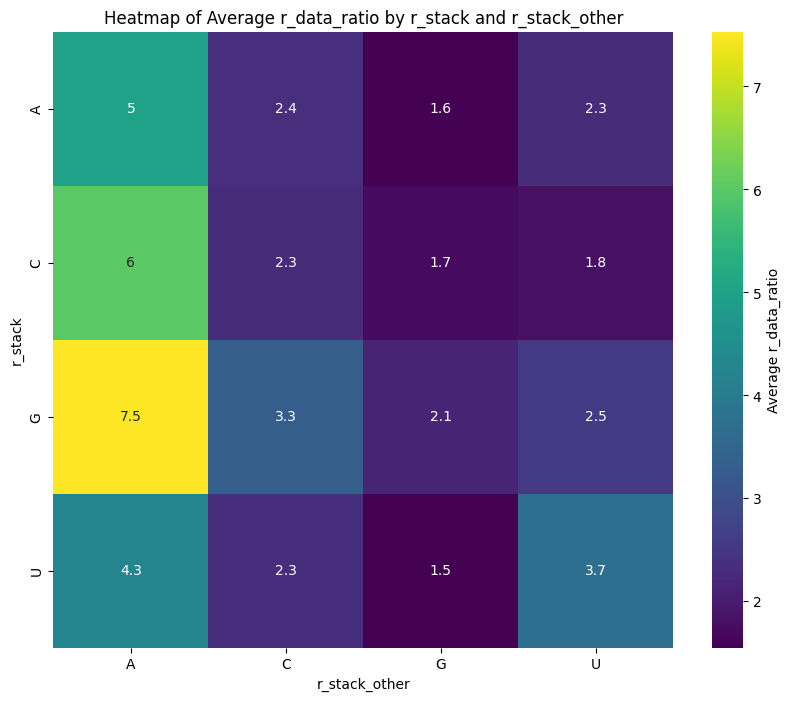

In [37]:
# Create a pivot table for the heatmap
df_sub = df_aa_combined.query("m_token == '2x2'")
heatmap_data = df_sub.pivot_table(
    index="p3_res", columns="p3_res_other", values="r_data_ratio", aggfunc="mean"
)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data, annot=True, cmap="viridis", cbar_kws={"label": "Average r_data_ratio"}
)
plt.title("Heatmap of Average r_data_ratio by r_stack and r_stack_other")
plt.xlabel("r_stack_other")
plt.ylabel("r_stack")

### what motifs have the highest ratios

In [38]:
df_aa_combined = df_aa_combined.sort_values(by="r_data_ratio", ascending=False)
# Calculate the average r_data_ratio for each unique m_sequence

In [39]:
# Calculate the average r_data_ratio for each unique m_sequence
average_ratios = (
    df_aa_combined.groupby("m_sequence")["r_data_ratio"]
    .mean()
    .sort_values(ascending=False)
)

# Get the top 10 unique m_sequences with the highest average ratio
top_10_sequences = average_ratios.head(10)

# Create a table-like output
print("Top 10 Unique m_sequences with Highest Average Ratio:")
print("-" * 50)
print(f"{'m_sequence':<15} | {'Average r_data_ratio':>20}")
print("-" * 50)
for sequence, ratio in top_10_sequences.items():
    print(f"{sequence:<15} | {ratio:>20.2f}")
print("-" * 50)

Top 10 Unique m_sequences with Highest Average Ratio:
--------------------------------------------------
m_sequence      | Average r_data_ratio
--------------------------------------------------
CAAA&UGAG       |                26.58
AGAG&CAAU       |                19.88
GAAA&UGAC       |                14.39
CAAG&CGAG       |                13.71
AAAA&UGAU       |                11.53
UAAA&UGAA       |                10.65
CGAC&GAAG       |                10.58
AGAA&UAAU       |                10.02
AGAC&GAAU       |                 9.99
AAUA&UUAU       |                 9.26
--------------------------------------------------


<Axes: xlabel='Nucleotide', ylabel='Mutation Fraction'>

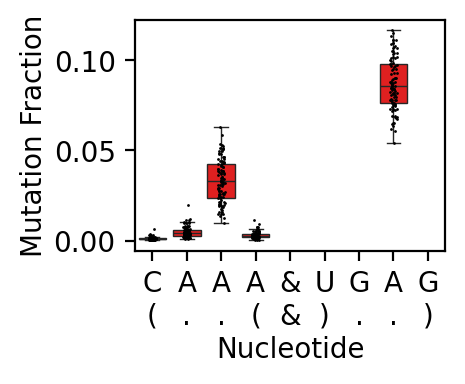

In [40]:
df_sub = df.query('m_sequence == "CAAA&UGAG"')
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_motif_boxplot_stripplot(df_sub, show_structure=True, ax=ax)

<Axes: xlabel='Nucleotide', ylabel='Mutation Fraction'>

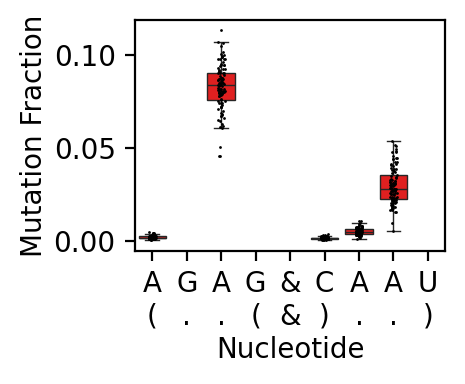

In [41]:
df_sub = df.query('m_sequence == "AGAG&CAAU"')
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_motif_boxplot_stripplot(df_sub, show_structure=True, ax=ax)

### which pdbs have the highest ratios

In [42]:
# Find the row with the highest ratio that has a PDB
highest_ratio_with_pdb = (
    df_aa_combined[df_aa_combined["has_pdbs"] == True]
    .sort_values(by="r_data_ratio", ascending=False)
    .iloc[0]
)

print(f"Highest ratio with PDB: {highest_ratio_with_pdb['r_data_ratio']:.2f}")
print(f"PDB path: {highest_ratio_with_pdb['pdb_path']}")

Highest ratio with PDB: 20.05
PDB path: ['data/pdbs_w_2bp/AAAG_CGAU/TWOWAY.5O5J.2-2.AAAG-CGAU.0.pdb']


In [43]:
# Example usage:
highest_ratio_with_pdb["pdb_path"] = highest_ratio_with_pdb["pdb_path"][0]
viewer = visualize_molecule(highest_ratio_with_pdb)
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [44]:
row_with_pdbs = (
    df_aa_combined[df_aa_combined["has_pdbs"] == True]
    .query("r_stack == 'GG'")
    .sort_values(by="r_data_ratio", ascending=False)
    .iloc[0]
)
print(row_with_pdbs)

both_purine                                                          True
both_pyrimidine                                                     False
constructs                                                  construct1367
has_pdbs                                                             True
likely_pair                                                            AA
m_flank_bp_5p                                                          CG
m_flank_bp_3p                                                          CG
m_orientation                                                 non-flipped
m_pos                                                                   0
m_second_flank_bp_5p                                                   CG
m_second_flank_bp_3p                                                   UA
m_sequence                                                        CAC&GAG
m_structure                                                       (.(&).)
m_token                               

In [45]:
# This is not a good example is the other A is stacking on another residue not here
row_with_pdbs["pdb_path"] = row_with_pdbs["pdb_path"][0]
viewer = visualize_molecule(row_with_pdbs)
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### why is there a large spread

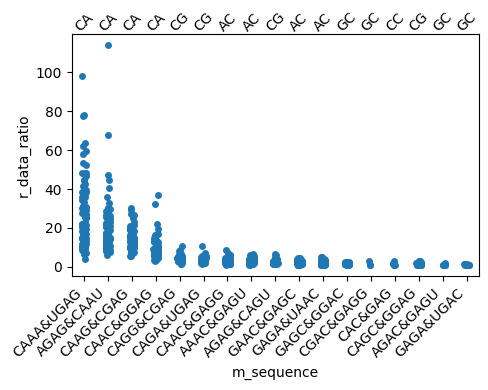

In [46]:
df_gg_stack = df_aa_combined.query("r_stack == 'GG'")
df_gg_stack = df_gg_stack.sort_values(by="r_data_ratio", ascending=False)

# Calculate average r_data_ratio for each unique m_sequence
avg_ratios = (
    df_gg_stack.groupby("m_sequence")["r_data_ratio"]
    .mean()
    .sort_values(ascending=False)
)

# Plot average ratios as a stripplot
plt.figure(figsize=(5, 4))
sns.stripplot(
    x="m_sequence", y="r_data_ratio", data=df_gg_stack, order=avg_ratios.index
)
plt.xlabel("m_sequence")
plt.ylabel("r_data_ratio")
plt.xticks(rotation=45, ha="right")

# Add r_stack_other value to the plot
for i, m_seq in enumerate(avg_ratios.index):
    r_stack_other = df_gg_stack[df_gg_stack["m_sequence"] == m_seq][
        "r_stack_other"
    ].iloc[0]
    plt.text(
        i, plt.ylim()[1], f"{r_stack_other}", ha="center", va="bottom", rotation=45
    )

plt.tight_layout()

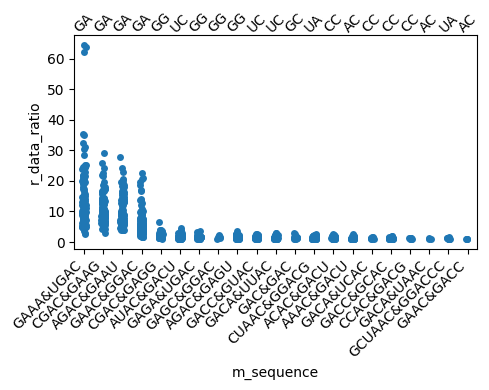

In [47]:
df_gg_stack = df_aa_combined.query("r_stack == 'GC'")
df_gg_stack = df_gg_stack.sort_values(by="r_data_ratio", ascending=False)

# Calculate average r_data_ratio for each unique m_sequence
avg_ratios = (
    df_gg_stack.groupby("m_sequence")["r_data_ratio"]
    .mean()
    .sort_values(ascending=False)
)

# Plot average ratios as a stripplot
plt.figure(figsize=(5, 4))
sns.stripplot(
    x="m_sequence", y="r_data_ratio", data=df_gg_stack, order=avg_ratios.index
)
plt.xlabel("m_sequence")
plt.ylabel("r_data_ratio")
plt.xticks(rotation=45, ha="right")

# Add r_stack_other value to the plot
for i, m_seq in enumerate(avg_ratios.index):
    r_stack_other = df_gg_stack[df_gg_stack["m_sequence"] == m_seq][
        "r_stack_other"
    ].iloc[0]
    plt.text(
        i, plt.ylim()[1], f"{r_stack_other}", ha="center", va="bottom", rotation=45
    )

plt.tight_layout()

<Axes: xlabel='Nucleotide', ylabel='Mutation Fraction'>

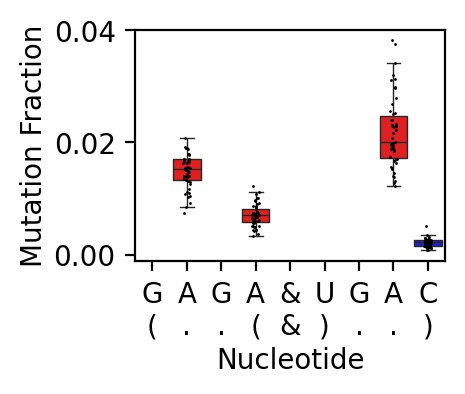

In [48]:
df_sub = df.query('m_sequence == "GAGA&UGAC"')
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
plot_motif_boxplot_stripplot(df_sub, show_structure=True, ax=ax)

### is the large spread in ratio related to second flanking base pairs

In [49]:
# Calculate the mean of r_data_ratio for each m_orientation
mean_r_data_ratio = (
    df_gg_stack.groupby("m_orientation")["r_data_ratio"].mean().reset_index()
)
# Display the results as a table
display(mean_r_data_ratio.style.format({"r_data_ratio": "{:.2f}"}))

,m_orientation,r_data_ratio
0,flipped,5.84
1,non-flipped,4.83


In [50]:
heatmap_table(
    df_gg_stack.query("m_token == '2x2'"),
    "m_second_flank_bp_5p",
    "m_second_flank_bp_3p",
    "r_data_ratio",
)

m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,4.6,7.1,4.0,4.7
CG,3.9,6.1,5.5,5.0
GC,7.0,5.5,8.4,9.0
UA,5.5,6.6,6.7,5.3
m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,4.86,6.75,4.51,4.37
CG,4.36,7.36,5.93,5.52
GC,10.56,6.47,9.97,13.02


In [51]:
heatmap_table(
    df_aa_combined, "m_second_flank_bp_5p", "m_second_flank_bp_3p", "r_data_ratio"
)

m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,3.2,3.6,3.8,3.3
CG,3.7,3.7,3.9,3.6
GC,3.3,3.2,3.6,3.5
UA,3.4,3.4,4.0,3.5
m_second_flank_bp_3p,AU,CG,GC,UA
m_second_flank_bp_5p,,,,
AU,4.17,4.63,7.14,4.45
CG,5.81,5.50,6.11,5.14
GC,4.38,3.31,4.68,5.12


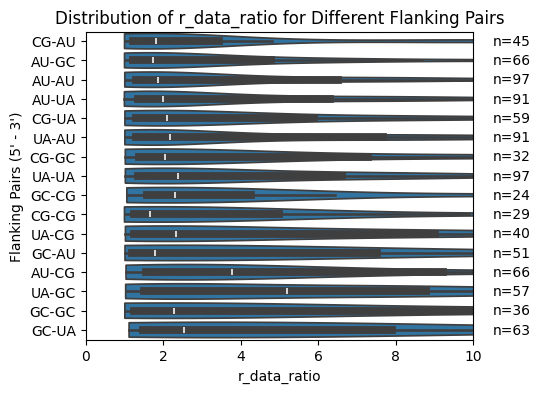

In [52]:
plot_flanking_pairs_distribution(df_gg_stack)

# single mismatches

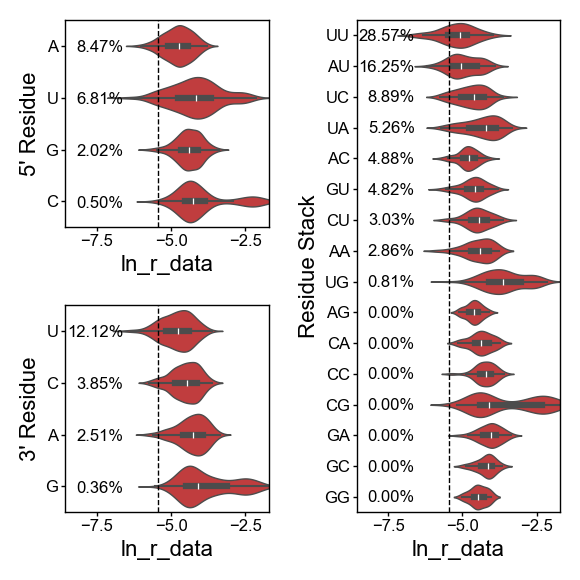

In [53]:
df_aa_1x1 = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA' and m_token == '1x1'"
).copy()
plot_residue_trends(df_aa_1x1, color="tab:red")

In [54]:
create_summary_table(df_aa_1x1, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| UU        | 28.57%          |      35 |
| AU        | 16.25%          |      80 |
| UC        | 8.89%           |      45 |
| UA        | 5.26%           |      76 |
| AC        | 4.88%           |      41 |
| GU        | 4.82%           |      83 |
| CU        | 3.03%           |      33 |
| AA        | 2.86%           |      35 |
| UG        | 0.81%           |     123 |
| AG        | 0.00%           |      33 |
| CA        | 0.00%           |      43 |
| CC        | 0.00%           |      36 |
| GG        | 0.00%           |      36 |
| CG        | 0.00%           |      88 |
| GA        | 0.00%           |      45 |
| GC        | 0.00%           |      34 |


/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/dms_3d_features/plotting.py:438: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(


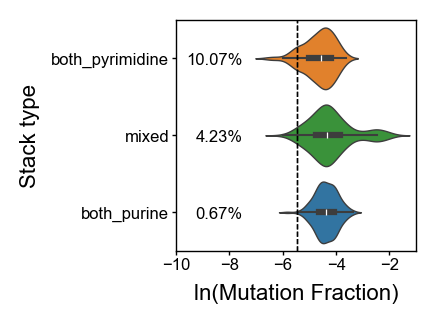

In [55]:
df_aa_1x1 = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA' and m_token == '1x1'"
).copy()
df_aa_1x1["stack_type"] = df_aa_1x1.apply(assign_stack_type, axis=1)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = plot_violins_w_percent(
    df_aa_1x1,
    "ln_r_data",
    "stack_type",
    color=None,
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_xlim(-10, -1)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_ylabel("Stack type")
ax.set_xlabel("ln(Mutation Fraction)")
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)

# 2x2 double mismatches

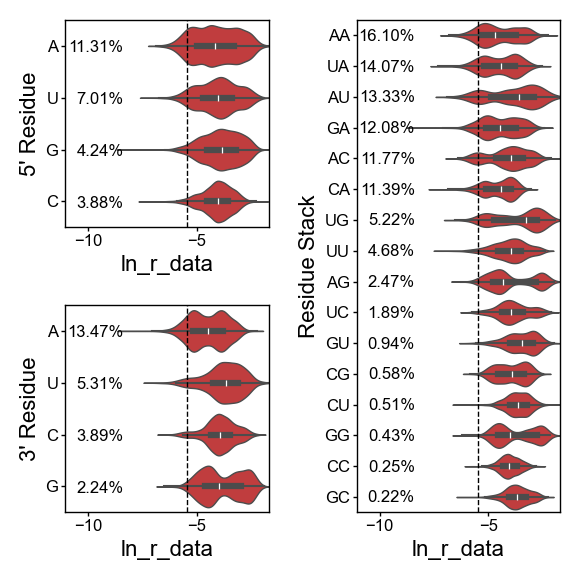

In [56]:
df_aa_2x2 = df.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and likely_pair == 'AA' and m_token == '2x2'"
).copy()
plot_residue_trends(df_aa_2x2, color="tab:red")

In [57]:
create_summary_table(df_aa_2x2, "r_stack")
# with PDB info with known pairs

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| AA        | 16.10%          |    2075 |
| UA        | 14.07%          |    1954 |
| AU        | 13.33%          |    1575 |
| GA        | 12.08%          |    1780 |
| AC        | 11.77%          |    1784 |
| CA        | 11.39%          |    1993 |
| UG        | 5.22%           |    1360 |
| UU        | 4.68%           |    1390 |
| AG        | 2.47%           |    1579 |
| UC        | 1.89%           |    1590 |
| GU        | 0.94%           |    1173 |
| CG        | 0.58%           |    1387 |
| CU        | 0.51%           |    1375 |
| GG        | 0.43%           |    1176 |
| CC        | 0.25%           |    1588 |
| GC        | 0.22%           |    1385 |


# with PDB info with known pairs

## stacking

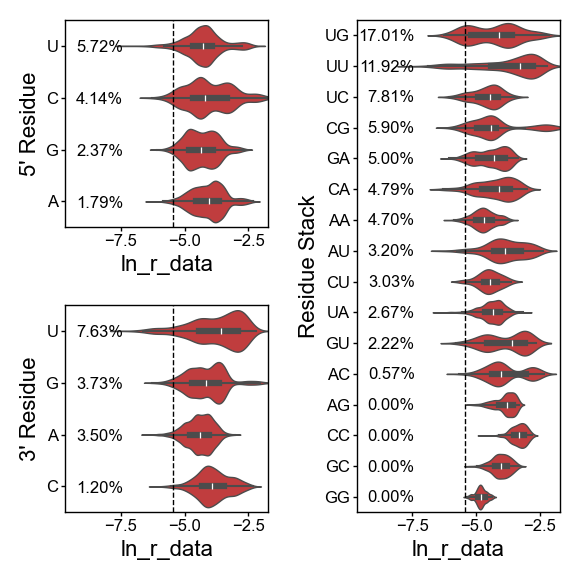

In [58]:
df_pdb_aa = df_pdb.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and pdb_r_pair == 'A-A' and no_of_interactions == 1"
).copy()
plot_residue_trends(df_pdb_aa, color="tab:red")

In [59]:
create_summary_table(df_pdb_aa, "r_stack")

Summary table for r_stack:
| r_stack   | % Under -5.45   |   Count |
|:----------|:----------------|--------:|
| UG        | 17.01%          |     288 |
| UU        | 11.92%          |     520 |
| UC        | 7.81%           |     128 |
| CG        | 5.90%           |     424 |
| GA        | 5.00%           |     580 |
| CA        | 4.79%           |     167 |
| AA        | 4.70%           |     617 |
| AU        | 3.20%           |     250 |
| CU        | 3.03%           |      33 |
| UA        | 2.67%           |    2212 |
| GU        | 2.22%           |     180 |
| AC        | 0.57%           |     353 |
| AG        | 0.00%           |     962 |
| GC        | 0.00%           |     325 |
| CC        | 0.00%           |     197 |
| GG        | 0.00%           |     309 |


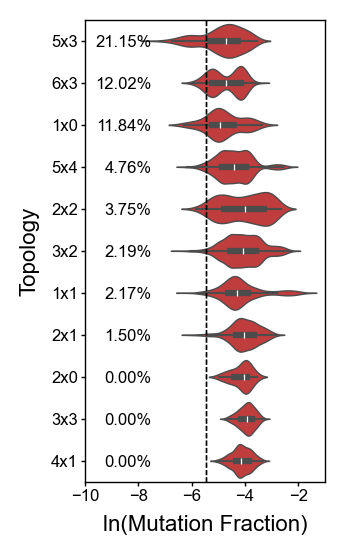

In [60]:
fig, ax = plt.subplots(figsize=(2.0, 3.0), dpi=200)
ax = plot_violins_w_percent(
    df_pdb_aa,
    "ln_r_data",
    "m_token",
    color="tab:red",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_xlim(-10, -1)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_ylabel("Topology")
ax.set_xlabel("ln(Mutation Fraction)")
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)

In [61]:
df_pdb_aa.query("m_token.isnull()")

,m_sequence,r_nuc,pdb_r_pos,partner_nuc,pdb_partner_pos,r_type,pdb_r_bp_type,pdb_r_pair,no_of_conformations,no_of_interactions,...,p3_res,p3_type,r_data,r_loc_pos,r_pos,r_stack,ln_r_data,z_score,r_data_outlier,pair_pdb_r_pos


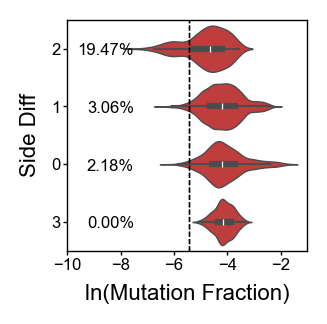

In [62]:
df_pdb_aa = df_pdb_aa.query("not m_token.isnull()")
df_pdb_aa = df_pdb_aa.query("m_token != '6x3'")
df_pdb_aa.query("m_token.isnull()")
df_pdb_aa = add_side_diff_column(df_pdb_aa)
fig, ax = plt.subplots(figsize=(2.0, 1.5), dpi=200)
ax = plot_violins_w_percent(
    df_pdb_aa,
    "ln_r_data",
    "side_diff",
    color="tab:red",
    gt_lt="less",
    xlim=(-10, -1),
    sorted_by_mean=True,
    ax=ax,
)
ax.set_xlim(-10, -1)
ax.set_xticks([-10, -8, -6, -4, -2])
ax.set_ylabel("Side Diff")
ax.set_xlabel("ln(Mutation Fraction)")
ax.axvline(-5.45, color="black", linestyle="--", lw=0.5)
format_small_plot(ax)

In [63]:
df_pdb_aa.columns

Index(['m_sequence', 'r_nuc', 'pdb_r_pos', 'partner_nuc', 'pdb_partner_pos',
       'r_type', 'pdb_r_bp_type', 'pdb_r_pair', 'no_of_conformations',
       'no_of_interactions', 'no_of_partner_interactions', 'pdb_name',
       'pdb_path', 'pdb_res', 'both_purine', 'both_pyrimidine', 'constructs',
       'likely_pair', 'm_flank_bp_5p', 'm_flank_bp_3p', 'm_orientation',
       'm_pos', 'm_second_flank_bp_5p', 'm_second_flank_bp_3p', 'm_structure',
       'm_token', 'n_pdbs', 'pair_type', 'p5_res', 'p5_type', 'p3_res',
       'p3_type', 'r_data', 'r_loc_pos', 'r_pos', 'r_stack', 'ln_r_data',
       'z_score', 'r_data_outlier', 'pair_pdb_r_pos', 'side_diff'],
      dtype='object')

In [64]:
df_pdb_aa.groupby("pdb_r_bp_type").agg(
    avg_ln_r_data=("ln_r_data", "mean"),
    std_ln_r_data=("ln_r_data", "std"),
    count=("ln_r_data", "size"),
).reset_index()

,pdb_r_bp_type,avg_ln_r_data,std_ln_r_data,count
0,cHS,-3.836657,0.476705,825
1,cHW,-3.880890,0.812818,230
2,cSH,-4.515249,0.398260,1112
3,cWH,-3.885073,0.657706,230
4,cWW,-4.084370,0.754445,942
5,tHH,-4.455773,0.549379,1034
6,tHS,-3.601163,0.686914,1088
7,tHW,-4.124114,0.344773,104
8,tSH,-4.663714,0.606642,968
9,tWW,-4.294313,0.862363,804


## pdb atom distances

In [65]:
df_dist = pd.read_csv("../data/pdb-features/distances_all.csv")

In [66]:
def calculate_atom_distances(df, df_dist, r_atom, pair_atom):
    data = []
    data_ratio = []
    seen = []
    for i, g in df.groupby(["pdb_name", "pdb_r_pos"]):
        row = g.iloc[0]
        if row["pair_pdb_r_pos"] == -1:
            continue
        if row.pdb_r_pos < row.pair_pdb_r_pos:
            df_sub = df_dist.query(
                f'pdb_name == "{row.pdb_name}" and '
                f"res_num1 == {row.pdb_r_pos} and res_num2 == {row.pair_pdb_r_pos} and "
                f'atom_name1 == "{r_atom}" and atom_name2 == "{pair_atom}"'
            )
        else:
            df_sub = df_dist.query(
                f'pdb_name == "{row.pdb_name}" and '
                f"res_num1 == {row.pair_pdb_r_pos} and res_num2 == {row.pdb_r_pos} and "
                f'atom_name1 == "{pair_atom}" and atom_name2 == "{r_atom}"'
            )
        if len(df_sub) == 0:
            # print("couldnt find distance")
            continue
        data.append(
            {
                "pdb_name": row.pdb_path,
                "pdb_r_pos": row.pdb_r_pos,
                "pair_pdb_r_pos": row.pair_pdb_r_pos,
                "pdb_r_bp_type": row.pdb_r_bp_type,
                "distance": df_sub.iloc[0]["distance"],
                "pdb_res": row.pdb_res,
                "ln_r_data_mean": g["ln_r_data"].mean(),
                "ln_r_data_std": g["ln_r_data"].std(),
            }
        )
        key = (row.pdb_name, row.pdb_r_pos, row.pair_pdb_r_pos)
        partner_key = (row.pdb_name, row.pair_pdb_r_pos, row.pdb_r_pos)
        if key in seen or partner_key in seen:
            continue
        seen.append(key)
        seen.append(partner_key)
        partner_g = df.query(
            f'pdb_name == "{row.pdb_name}" and pdb_r_pos == {row.pair_pdb_r_pos}'
        )
        ratio = g["ln_r_data"].mean() / partner_g["ln_r_data"].mean()
        data_ratio.append(
            {
                "pdb_name": row.pdb_path,
                "pdb_r_pos": row.pdb_r_pos,
                "pair_pdb_r_pos": row.pair_pdb_r_pos,
                "distance": df_sub.iloc[0]["distance"],
                "pdb_res": row.pdb_res,
                "ratio": ratio,
            }
        )
        if len(partner_g) == 0:
            continue
    return pd.DataFrame(data), pd.DataFrame(data_ratio)


# Example usage:
df_pdb_aa = df_pdb.query(
    "r_nuc == 'A' and r_type == 'NON-WC' and pdb_r_pair == 'A-A' and no_of_interactions == 1"
).copy()
df_dist_aa, df_dist_aa_ratio = calculate_atom_distances(df_pdb_aa, df_dist, "N1", "N1")

In [67]:
def calculate_atom_distances_with_ratio(df, df_dist, r_atom, pair_atom, df_pdb):
    data_ratio = []
    seen = []
    for i, g in df.groupby(["pdb_name", "pdb_r_pos"]):
        row = g.iloc[0]
        if row["pair_pdb_r_pos"] == -1:
            continue
        if row.pdb_r_pos < row.pair_pdb_r_pos:
            df_sub = df_dist.query(
                f'pdb_name == "{row.pdb_name}" and '
                f"res_num1 == {row.pdb_r_pos} and res_num2 == {row.pair_pdb_r_pos} and "
                f'atom_name1 == "{r_atom}" and atom_name2 == "{pair_atom}"'
            )
        else:
            df_sub = df_dist.query(
                f'pdb_name == "{row.pdb_name}" and '
                f"res_num1 == {row.pair_pdb_r_pos} and res_num2 == {row.pdb_r_pos} and "
                f'atom_name1 == "{pair_atom}" and atom_name2 == "{r_atom}"'
            )
        if len(df_sub) == 0:
            continue

        key = (row.pdb_name, row.pdb_r_pos, row.pair_pdb_r_pos)
        partner_key = (row.pdb_name, row.pair_pdb_r_pos, row.pdb_r_pos)
        if key in seen or partner_key in seen:
            continue
        seen.append(key)
        seen.append(partner_key)
        partner_g = df_pdb.query(
            f'pdb_name == "{row.pdb_name}" and pdb_r_pos == {row.pair_pdb_r_pos}'
        )
        if len(partner_g) == 0:
            continue
        ratio = g["ln_r_data"].mean() / partner_g["ln_r_data"].mean()
        data_ratio.append(
            {
                "pdb_name": row.pdb_path,
                "pdb_r_pos": row.pdb_r_pos,
                "pair_pdb_r_pos": row.pair_pdb_r_pos,
                "distance": df_sub.iloc[0]["distance"],
                "pdb_res": row.pdb_res,
                "ratio": ratio,
                "pdb_r_bp_type": row.pdb_r_bp_type,
            }
        )

    return pd.DataFrame(data_ratio)

In [68]:
df_dist_aa_ratio = calculate_atom_distances_with_ratio(
    df_pdb_aa, df_dist, "O3'", "N6", df_pdb
)

In [69]:
df_dist_aa_ratio.sort_values("distance", ascending=True, inplace=True)
# Prepare the data

In [70]:
df_dist_aa_ratio.groupby("pdb_r_bp_type").agg(
    avg_ratio=("ratio", "mean"),
    std_ratio=("ratio", "std"),
    count=("ratio", "size"),
).reset_index()

,pdb_r_bp_type,avg_ratio,std_ratio,count
0,cHW,0.952040,NaN,1
1,cWH,0.993845,0.083500,4
2,cWW,0.962657,0.175316,10
3,tHH,1.207375,0.057314,5
4,tHS,0.877722,0.162366,4
5,tHW,1.025888,NaN,1
6,tSH,1.555518,0.222775,6
7,tWW,1.179733,0.036220,4


In [83]:
print(df_dist_aa_ratio.iloc[0]["pdb_name"])
print(df_dist_aa_ratio.iloc[0]["pdb_r_pos"])
print(df_dist_aa_ratio.iloc[0]["distance"])
print(df_dist_aa_ratio.iloc[0]["ratio"])
print(df_dist_aa_ratio.iloc[0]["pdb_r_bp_type"])

data/pdbs_w_2bp/AAACG_CUAU/TWOWAY.1NJP.2-3.CUAU-AAACG.0.pdb
4
5.07
1.6243258125547069
tSH


In [84]:
print(df_dist_aa_ratio.iloc[9]["pdb_name"])
print(df_dist_aa_ratio.iloc[9]["pdb_r_pos"])
print(df_dist_aa_ratio.iloc[9]["distance"])
print(df_dist_aa_ratio.iloc[9]["ratio"])
print(df_dist_aa_ratio.iloc[9]["pdb_r_bp_type"])

data/pdbs_w_2bp/UUAGUAC_GGAAUA/NWAY.1UN6.2-5-0.AAUA-UUAGUAC-GG.0.pdb
5
8.91
1.3088906645044693
tHH


In [73]:
print(df_dist_aa_ratio.iloc[-1]["pdb_name"])
print(df_dist_aa_ratio.iloc[-1]["pdb_r_pos"])
print(df_dist_aa_ratio.iloc[-1]["distance"])
print(df_dist_aa_ratio.iloc[-1]["pdb_r_bp_type"])

data/pdbs_w_2bp/CGACGAAG_CAGAG/TWOWAY.4KQY.3-6.CAGAG-CGACGAAG.0.pdb
9
13.57
tHS


In [82]:
print(df_dist_aa_ratio.iloc[2]["pdb_name"])
print(df_dist_aa_ratio.iloc[2]["pdb_r_pos"])
print(df_dist_aa_ratio.iloc[2]["distance"])
print(df_dist_aa_ratio.iloc[2]["ratio"])
print(df_dist_aa_ratio.iloc[9]["pdb_r_bp_type"])

data/pdbs_w_2bp/AAAG_CGAU/TWOWAY.5O5J.2-2.AAAG-CGAU.0.pdb
4
5.29
1.5758917140464155
tHH


R-squared: 0.5954623192812829


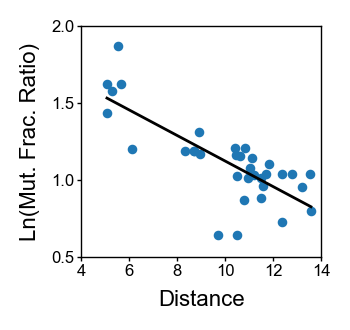

In [75]:
def plot_distance_vs_ratio(df_dist_aa_ratio):
    # Prepare the data
    X = df_dist_aa_ratio["distance"].values.reshape(-1, 1)
    y = df_dist_aa_ratio["ratio"].values

    # Remove any rows with NaN values
    mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    X = X[mask]
    y = y[mask]
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Compute R-squared
    r2 = r2_score(y, model.predict(X))

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(2, 1.5), dpi=200)
    ax.scatter(X.flatten(), y, s=6)

    # Add regression line
    ax.plot(X, model.predict(X), color="black", linewidth=1)
    return fig, ax, r2


# Usage:
fig, ax, r2 = plot_distance_vs_ratio(df_dist_aa_ratio)
ax.set_xlabel("Distance")
ax.set_ylabel("Ln(Mut. Frac. Ratio)")
ax.set_xticks([4, 6, 8, 10, 12, 14])
ax.set_yticks([0.5, 1.0, 1.5, 2.0])
print(f"R-squared: {r2}")
format_small_plot(ax)